#  **Recipe and Nutritional Data Pipeline**

This notebook outlines a comprehensive pipeline for processing and enriching recipe data, including ingredient parsing, nutritional enrichment, unit conversions, and final data export. The data is cleaned, ingredients are normalized, and nutritional values are derived from multiple sources, including Open Food Facts.

---

## **1. Data Cleaning and Preparation**
### **Initial Dataset Inspection**
- The recipe dataset is loaded using **pandas**.
- Basic inspections are conducted using `.info()` and `.head()` to understand the structure and identify any missing or malformed data.

### **Data Filtering**
- Rows with **missing `ingredients_raw`** or improperly formatted ingredient lists are dropped.
- Ingredient lists are validated and parsed using `ast.literal_eval()` and `ingredient-parser`, ensuring they are structured correctly for further processing.

### **Exploding Ingredients**
- Ingredients for each recipe are exploded into individual rows using **`explode()`** in pandas, so that each row represents a single ingredient paired with a recipe ID for easy analysis.

---

## **2. Ingredient and Unit Parsing**
### **Ingredient Normalization**
- Ingredients are cleaned and normalized by applying **NLP techniques** with `parse_ingredient()`.
- Special handling for ambiguous ingredients (e.g., “1/2 tsp or 1 tsp”) using fallback mechanisms and **regex** to ensure consistent names and units.

### **Unit Conversion**
- Volume-based units (like cups, teaspoons) are converted into weight (grams) using **external density data**.
- Uses **FAISS (vector search)** and **LLM-based fallback** (via Ollama) to handle cases where standard conversion tables are not sufficient.

### **Ingredient Parsing Enhancements**
- The notebook includes logic to handle alternative ingredient names and quantities, ensuring no ingredient is missed or improperly parsed.
- Uses **FAISS** to match ingredients to known densities and **LLM** for fine-tuning unknown conversions.

---

## **3. Nutritional Data Enrichment**
### **Nutritional Lookup**
- Nutritional data is sourced from the **Open Food Facts** dataset, and ingredients are matched to their nutritional information via **semantic search** (embedding-based via FAISS).
- Fuzzy matching ensures accurate nutrition lookup for ambiguous ingredients.

### **Nutritional Aggregation**
- Total nutrition values (calories, protein, fat, carbs) are calculated per recipe by aggregating data from individual ingredients and adjusting based on the ingredient amounts.
- Nutritional values are scaled based on ingredient weights (converted to grams), and **serving sizes** are also normalized.

### **Unit Handling**
- A major portion of the notebook focuses on ensuring all ingredients are **converted to grams**, with the `amount_gram` column holding the final weights of each ingredient.
- The serving size (`serving_size_numeric`) is also normalized to allow for accurate per-serving nutritional computation.

---

## **4. Data Analysis and Filtering**
### **Approximation Rate Calculation**
- An **approximation rate** (`approx_rate`) is computed to compare the predicted total grams (based on ingredient weights) with the actual total grams (from serving size).
- The dataset is cleaned by filtering out recipes that have a significant mismatch between predicted and actual values.

### **Data Filtering**
- Recipes with **extreme approximation rates** (either too high or too low) are filtered out to ensure the dataset’s nutritional estimates are accurate.
- This step guarantees that the final dataset reflects the most reliable nutritional data.

### **Final Dataset**
- The final dataset, containing **validated, normalized, and enriched recipes**, is saved to `recipes_filtered.csv`.
- Only recipes with accurate and reliable nutritional estimations are kept.

---

## **5. Saving and Exporting Data**
### **Final Files**
- **`recipes_filtered.csv`**: Contains the cleaned and filtered recipes, enriched with accurate nutritional values and converted to grams.
- **`density.csv`**: Contains the final density data for ingredients, used for volume-to-gram conversion.

### **Backup and Final Export**
- The entire pipeline is saved into CSV files for future use:
  - Ingredient and nutritional data can now be easily queried and analyzed.
  - Density values are stored for easy access in future recipes or projects.

---

## **Key Insights and Next Steps**
1. **Final Dataset**: The resulting data is now **ready for integration** into nutritional apps, diet planners, or recommendation systems.
2. **LLM and FAISS**: The combination of semantic search and LLM integration allows the system to flexibly handle ambiguous or incomplete ingredient data.
3. **Unit Conversion**: The robust conversion of units ensures that all recipes, regardless of initial data quality, are converted into a standard measurement (grams), facilitating uniform nutrient calculations.

---

This notebook effectively prepares the data for any **nutritional analysis**, **diet recommendation engine**, or **recipe retrieval system**. The LLM-based augmentation enhances flexibility, while FAISS speeds up similarity-based queries.


In [ ]:
# The source of the recipes dataset : https://www.kaggle.com/datasets/realalexanderwei/food-com-recipes-with-ingredients-and-tags
# The dataset is a collection of recipes from the website Food.com. 
# Along with this dataset , we are going to use some others . 
# The dataset to extract nutritional values of the ingredients/foods : https://www.kaggle.com/datasets/openfoodfacts/world-food-facts/data
# We will also need a food density dataset to convert volumes to weight for distinct foods . 
# Density Databse is downloaded from https://www.fao.org and the related article can be found here : https://www.fao.org/fileadmin/templates/food_composition/documents/density_DB_v2_0_01.pdf
# We have also used https://www.kingarthurbaking.com/learn/ingredient-weight-chart to expand the density database. 
# We are going to start with exploring the recipes dataset. 

import pandas as pd
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the recipes dataset
recipes = pd.read_csv('C:/Users/turgu/sertifika/reciperesuggestion/Recipes_Ingredients/recipes_ingredients.csv')


In [3]:
# Let's examine the first few rows of the dataset
recipes.head()

,id,name,description,ingredients,ingredients_raw,steps,servings,serving_size,tags
0,71247,Cherry Streusel Cobbler,"I haven't made this in years, so I'm just gues...","[""cherry pie filling"", ""condensed milk"", ""melt...","[""2 (21 ounce) cans cherry pie filling"",""2...","[""Preheat oven to 375°F."", ""Spread cherry pie ...",6.0,1 (347 g),"[""60-minutes-or-less"", ""time-to-make"", ""course..."
1,76133,Reuben and Swiss Casserole Bake,I think this is even better than a reuben sand...,"[""corned beef chopped"", ""sauerkraut cold water...","[""1/2-1 lb corned beef, cooked and choppe...","[""Set oven to 350 degrees F."", ""Butter a 9 x 1...",4.0,1 (207 g),"[""60-minutes-or-less"", ""time-to-make"", ""course..."
2,503816,Yam-Pecan Recipe,A lady I work with heard me taking about ZWT a...,"[""unsalted butter"", ""vegetable oil"", ""all - pu...","[""3/4 cup unsalted butter, at room tempera...","[""Preheat oven to 350°F In a mixing bowl, usi...",8.0,1 (198 g),"[""time-to-make"", ""course"", ""main-ingredient"", ..."
3,418749,Tropical Orange Layer Cake,An easy and delicious cake. Great for a summ...,"[""orange cake mix"", ""instant vanilla pudding"",...","[""1 (18 ounce) pkge.orange cake mix"",""1 (3...","[""In a large mixing bowl, combine the first 6 ...",16.0,1 (191 g),"[""60-minutes-or-less"", ""time-to-make"", ""course..."
4,392934,Safe to Eat Raw Chocolate Chip Oreo Cookie &qu...,I was searching the web for something like thi...,"[""butter"", ""brown sugar"", ""granulated sugar"", ...","[""1/2 cup butter, room temperature "",""1/2 ...","[""Cream butter and sugars together."", ""Blend i...",24.0,1 (26 g),"[""15-minutes-or-less"", ""time-to-make"", ""course..."


In [4]:
# Let's check for general information about the dataset
recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500471 entries, 0 to 500470
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               500471 non-null  int64  
 1   name             500471 non-null  object 
 2   description      498285 non-null  object 
 3   ingredients      500471 non-null  object 
 4   ingredients_raw  500436 non-null  object 
 5   steps            500471 non-null  object 
 6   servings         499749 non-null  float64
 7   serving_size     500436 non-null  object 
 8   tags             500436 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 34.4+ MB


In [5]:
# There are ingredients without ingredients_raw values. Let's check how many of them are there.
missing_ingredients = recipes[recipes['ingredients_raw'].isnull()]
missing_count = missing_ingredients.shape[0]
print(f"Number of missing ingredients_raw values: {missing_count}")

Number of missing ingredients_raw values: 35


In [6]:
# Since ingredients_raw column has the amount of ingredients in the recipes, we can drop the rows with missing values.
# Let's drop the rows with missing ingredients_raw values , since there aren't too many of them.
recipes = recipes.dropna(subset=['ingredients_raw'])
recipes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500436 entries, 0 to 500470
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               500436 non-null  int64  
 1   name             500436 non-null  object 
 2   description      498250 non-null  object 
 3   ingredients      500436 non-null  object 
 4   ingredients_raw  500436 non-null  object 
 5   steps            500436 non-null  object 
 6   servings         499749 non-null  float64
 7   serving_size     500436 non-null  object 
 8   tags             500436 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 38.2+ MB


In [7]:
# Now we are going to create a separate dataset to hold ingredients.
# Ingredients for a recipe is held as a list of ingredients in the ingredients column.
# We need to extract these ingredients into a new DataFrame.
# Each ingredient will become its own row in the new DataFrame.
# There should also be a new column for the list of recipe IDs that correspond to each ingredient.

# First we are going to implement a helper function to get valid ingredients.
import ast

def is_valid_list(ing_str):
    try:
        ast.literal_eval(ing_str)  # Try converting string to a list
        return True
    except (SyntaxError, ValueError):  # Catch any conversion errors
        return False

# Apply the function to check each row
recipes["valid_ingredients"] = recipes["ingredients"].apply(is_valid_list)

# Identify problematic rows
invalid_rows = recipes[~recipes["valid_ingredients"]]

print("Count of the rows with syntax errors in ingredients:")
print(len(invalid_rows))

Count of the rows with syntax errors in ingredients:
11


In [8]:
# Let's get rid of the invalid rows since there aren't too many
recipes = recipes[recipes['valid_ingredients']]
recipes = recipes.drop(columns=['valid_ingredients']) # Drop the helper column

In [9]:
# Let's check the dataset now
recipes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500425 entries, 0 to 500470
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               500425 non-null  int64  
 1   name             500425 non-null  object 
 2   description      498239 non-null  object 
 3   ingredients      500425 non-null  object 
 4   ingredients_raw  500425 non-null  object 
 5   steps            500425 non-null  object 
 6   servings         499738 non-null  float64
 7   serving_size     500425 non-null  object 
 8   tags             500425 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 38.2+ MB


In [10]:
# Now let's create a separate exploded ingredients DataFrame without modifying the original one.

ingredients = recipes.copy()
ingredients['ingredients'] = ingredients['ingredients'].apply(ast.literal_eval) # Convert strings to lists
ingredients = ingredients.explode('ingredients')[['id','ingredients']].reset_index(drop = True)

# Let's also aggregate recipeIDs in a separate column , grouping them by ingredient.
ingredients = ingredients.groupby('ingredients')['id'].agg(lambda x: list(set(x))).reset_index()
ingredients['num_recipes'] = ingredients['id'].apply(len)
ingredients = ingredients.sort_values(by='num_recipes', ascending=False)

ingredients.head()

,ingredients,id,num_recipes
161175,olive oil,"[131072, 262148, 524293, 131078, 131077, 39322...",65533
235523,vanilla,"[131073, 262150, 524298, 262155, 131086, 52430...",48678
161978,onion,"[393222, 131079, 524294, 393223, 131082, 52430...",48258
31014,brown sugar,"[524288, 393222, 262157, 262158, 262161, 52431...",40704
17540,baking powder,"[262155, 262163, 262169, 393243, 393246, 39325...",37886


In [11]:
ingredients['num_recipes']

161175    65533
235523    48678
161978    48258
31014     40704
17540     37886
          ...  
95212         1
95213         1
95214         1
95215         1
251105        1
Name: num_recipes, Length: 251106, dtype: int64

In [12]:
# There are many rows with an ingredient occured only once . Let's check them 
ingredients.tail(20)

,ingredients,id,num_recipes
95192,fresh basil rough chop,[49497],1
95194,fresh basil rough chopped sauce garnish,[397274],1
95195,fresh basil sage,[137260],1
95196,fresh basil salad,[505661],1
95197,fresh basil sauce garnish,[403000],1
95198,fresh basil shaved parmesan cheese,[392874],1
95200,fresh basil shredded chopped,[51740],1
95202,fresh basil slivers,[117186],1
95216,fresh basil thai basil holy basil,[284936],1
95203,fresh basil snipped chives fresh sage thyme or...,[475402],1


In [13]:
# Obviously, there are incorrect ingredient names.
# We will try to extract them from the raw_ingredients column of the recipes DataFrame.
# We are going to use an external library called ingredient-parser.
# First , let's explore how this library works . 
# For our example , we are going to use an the row with ID == 472321

from ingredient_parser import parse_ingredient, parse_multiple_ingredients
pd.set_option('display.max_colwidth', None)

example_recipe = recipes.loc[recipes['id'] == 472321, ['ingredients_raw', 'ingredients']]

print(example_recipe['ingredients'])
print(example_recipe['ingredients_raw'])

117776    ["’ Pita Chips", "Sabra® Garlic Hummus", "Sabra® Roasted Red Pepper Hummus", "grape tomatoes", "chopped zucchini", "chopped Greek olives", "chopped pepperoncini peppers", "shredded mozzarella cheese"]
Name: ingredients, dtype: object
117776    ["4   cups    Stacey’s Pita Chips","2   tablespoons    Sabra® Roasted Garlic Hummus, divided ","2   tablespoons    Sabra® Roasted Red Pepper Hummus, divided ","8 -10       grape tomatoes, cut in half lengthwise ","1/4  cup   chopped zucchini (about 1/4-inch chunks)","2   tablespoons   chopped Greek olives","2   tablespoons   chopped pepperoncini peppers","1 1/2  cups   shredded mozzarella cheese"]
Name: ingredients_raw, dtype: object


In [14]:
# Obviously , there are some important mistakes . 
# Pita Chips is extracted with a syntactic error -> ’ Pita Chips
# Chopped Greek Olive is not a right way to extract the ingredient . Chopped is the operation defined on the ingredient : Greek Olive
# Let's now check how ingredient-parser will deal with it . 

ingredients_raw_str = recipes.loc[recipes['id'] == 472321, 'ingredients_raw'].values[0]
ingredient_list = ast.literal_eval(ingredients_raw_str)
parse_multiple_ingredients(sentences=ingredient_list,string_units=True,separate_names=True)




[ParsedIngredient(name=[IngredientText(text='Stacey’s Pita Chips', confidence=0.999568, starting_index=2)], size=None, amount=[IngredientAmount(quantity=Fraction(4, 1), quantity_max=Fraction(4, 1), unit='cups', text='4 cups', confidence=0.999973, starting_index=0, APPROXIMATE=False, SINGULAR=False, RANGE=False, MULTIPLIER=False, PREPARED_INGREDIENT=False)], preparation=None, comment=None, purpose=None, foundation_foods=[], sentence='4   cups    Stacey’s Pita Chips'),
 ParsedIngredient(name=[IngredientText(text='Sabra® Roasted Garlic Hummus', confidence=0.99247, starting_index=2)], size=None, amount=[IngredientAmount(quantity=Fraction(2, 1), quantity_max=Fraction(2, 1), unit='tablespoons', text='2 tablespoons', confidence=0.999973, starting_index=0, APPROXIMATE=False, SINGULAR=False, RANGE=False, MULTIPLIER=False, PREPARED_INGREDIENT=False)], preparation=IngredientText(text='divided', confidence=0.999142, starting_index=7), comment=None, purpose=None, foundation_foods=[], sentence='2   

In [15]:
# There are also many rows that gives the ingredients like "this or that"
# It can be difficult to extract them. We will try to use ingredient-parser's methods to do it. 
# If it is difficult to deal with them , we will eliminate those rows for now.

parse_ingredient("1/4  cup   toasted pumpkin seeds or 1/4  cup    pepitas",separate_names=True)

ParsedIngredient(name=[IngredientText(text='pumpkin seeds', confidence=0.993728, starting_index=3)], size=None, amount=[IngredientAmount(quantity=Fraction(1, 4), quantity_max=Fraction(1, 4), unit=<Unit('cup')>, text='1/4 cups', confidence=0.999872, starting_index=0, APPROXIMATE=False, SINGULAR=False, RANGE=False, MULTIPLIER=False, PREPARED_INGREDIENT=True)], preparation=IngredientText(text='toasted', confidence=0.990183, starting_index=2), comment=IngredientText(text='or 1/4 cup pepitas', confidence=0.989077, starting_index=5), purpose=None, foundation_foods=[], sentence='1/4  cup   toasted pumpkin seeds or 1/4  cup    pepitas')

In [16]:
# It didn't parse properly . Now we are going to try again with an easier example.
list_of_parsed_ingreds = parse_multiple_ingredients(sentences=["1-2 tbsp olive oil or butter","1 tbsp olive oil or 2 gr butter"],separate_names=True)
list_of_parsed_ingreds

[ParsedIngredient(name=[IngredientText(text='olive oil', confidence=0.987143, starting_index=2), IngredientText(text='butter', confidence=0.998102, starting_index=5)], size=None, amount=[IngredientAmount(quantity=Fraction(1, 1), quantity_max=Fraction(2, 1), unit=<Unit('tablespoon')>, text='1-2 tbsp', confidence=0.99996, starting_index=0, APPROXIMATE=False, SINGULAR=False, RANGE=True, MULTIPLIER=False, PREPARED_INGREDIENT=False)], preparation=None, comment=None, purpose=None, foundation_foods=[], sentence='1-2 tbsp olive oil or butter'),
 ParsedIngredient(name=[IngredientText(text='olive oil', confidence=0.998993, starting_index=2)], size=None, amount=[IngredientAmount(quantity=Fraction(1, 1), quantity_max=Fraction(1, 1), unit=<Unit('tablespoon')>, text='1 tbsp', confidence=0.999796, starting_index=0, APPROXIMATE=False, SINGULAR=False, RANGE=False, MULTIPLIER=False, PREPARED_INGREDIENT=False)], preparation=None, comment=IngredientText(text='or 2 gr butter', confidence=0.961982, starting

In [17]:
# The problem here is , when the amount of different ingredients are the same , they can be splitted , otherwise they can't. 
# The first example was splitted properly into 2 different ingredients . For the second example , it didn't work.
# Let's get rid of the rows which include "or" word in their ingredients_raw column for now. 
# Let's collect them and see how many of them
filtered_df = recipes[recipes['ingredients_raw'].str.contains(r'\bor\b', na=False, regex=True)]
print(len(filtered_df))

159709


In [18]:
# Drop the rows
recipes = recipes[~recipes['ingredients_raw'].str.contains(r'\bor\b', na=False, regex=True)]

In [ ]:
# We want to extract the amounts together with measures
# Some of the measures doesn't make sense 
# If there aren't too many of them , we will delete those rows . 
 
import concurrent.futures
from tqdm.notebook import tqdm  

def process_row(idx, raw):
    """
    Processes a single row of ingredients.
    Returns:
      - local_units: dict mapping unit to a list containing the row index.
      - local_undefined: set of indices with errors.
    """
    local_units = {}
    local_undefined = set()
    try:
        sentences = ast.literal_eval(raw)
        parsed_sentences = parse_multiple_ingredients(sentences=sentences, separate_names=True)
    except ValueError as e:
        print(f"Error parsing ingredients at index {idx}: {e}")
        local_undefined.add(idx)
        return local_units, local_undefined

    for parsed_ingredient in parsed_sentences:
        for amount in parsed_ingredient.amount:
            try:
                unit = amount.unit
                local_units.setdefault(unit, []).append(idx)
                
            except Exception as inner_error:
                local_undefined.add(idx)
    return local_units, local_undefined

results = []
# Create a list of tasks from the ingredient items.
tasks = list(recipes['ingredients_raw'].items())

# Using ThreadPoolExecutor for concurrency 
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_row, idx, raw) for idx, raw in tasks]
    # Wrap the as_completed iterator with tqdm for a progress bar
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Processing rows"):
        results.append(future.result())

# Aggregate results from all threads
all_units = {}
undefined_units_index = set()
for local_units, local_undefined in results:
    undefined_units_index.update(local_undefined)
    for unit, idx_list in local_units.items():
        all_units.setdefault(unit, []).extend(idx_list)

# Convert the aggregated units dictionary to a DataFrame
df_units = pd.DataFrame(list(all_units.items()), columns=['unit', 'id_list'])

# Display the DataFrame and undefined indices
print(df_units)
print("Rows with undefined units (to be removed):", undefined_units_index)




Processing rows:   0%|          | 0/340716 [00:00<?, ?it/s]

Error parsing ingredients at index 19102: Unit expression cannot have a scaling factor.
                 unit  \
0                 cup   
1                       
2          tablespoon   
3            teaspoon   
4              slices   
...               ...   
1460     g small tins   
1461  ounces portions   
1462     large loaves   
1463       scant drop   
1464       bunch bulb   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              id_list  
0                  [3506, 3

In [21]:
len(undefined_units_index)

687

In [39]:
# Since there aren't many of the undefined units index , we are going to delete them . 
recipes.drop(index=undefined_units_index, inplace=True)

In [42]:
#Let's create another column for how many elements in each unit's id list
df_units['count'] = df_units['id_list'].apply(len)

In [78]:
df_units.sort_values('unique_count',ascending=False,inplace=True)

In [46]:
df_units.describe()

,count
count,1465.000000
mean,2123.304437
std,32913.215049
min,1.000000
25%,1.000000
50%,2.000000
75%,6.000000
max,906707.000000


In [56]:
# Let's also create a column for unique indices and for it's length so we can find a threshold to drop the rows from the recipes dataframe.
df_units['id_set'] = df_units['id_list'].apply(set)


In [58]:
df_units['unique_count'] = df_units['id_set'].apply(len)

In [81]:
cumulative_set=set()
for index,row in df_units.iloc[::-1].iterrows():
    cumulative_set.update(row['id_set'])
    print(f"After row {index}, unique count: {len(cumulative_set)}")


After row 1464, unique count: 1
After row 1462, unique count: 2
After row 1461, unique count: 3
After row 1460, unique count: 4
After row 1459, unique count: 5
After row 1458, unique count: 6
After row 1457, unique count: 7
After row 1456, unique count: 8
After row 1455, unique count: 9
After row 1454, unique count: 10
After row 1453, unique count: 11
After row 1452, unique count: 12
After row 1451, unique count: 13
After row 1450, unique count: 14
After row 1449, unique count: 15
After row 1448, unique count: 16
After row 1447, unique count: 17
After row 1446, unique count: 18
After row 1463, unique count: 19
After row 1444, unique count: 20
After row 1443, unique count: 21
After row 1442, unique count: 22
After row 1439, unique count: 23
After row 1438, unique count: 24
After row 1437, unique count: 25
After row 1436, unique count: 26
After row 1435, unique count: 27
After row 1434, unique count: 28
After row 1433, unique count: 29
After row 1441, unique count: 30
After row 1445, uni

In [103]:
print(len(df_units.loc[:10]))
df_units.loc[:10]

33


,unit,id_list,count,id_set,unique_count
0,cup,"[3506, 3506, 3506, 314, 314, 649, 649, 649, 649, 1304, 1304, 1304, 1304, 1640, 1640, 2823, 323, 323, 323, 323, 323, 249, 249, 249, 249, 2652, 2652, 2652, 2652, 2652, 1451, 1451, 1451, 455, 455, 455, 2966, 2966, 2654, 2654, 1975, 1975, 3508, 650, 650, 1305, 1305, 305, 305, 305, 305, 305, 1974, 66, 66, 66, 66, 2824, 2824, 2824, 2824, 2824, 3509, 3509, 457, 457, 1643, 1643, 1643, 1643, 1452, 2825, 2825, 2825, 2825, 297, 297, 1306, 302, 2656, 1455, 1455, 1455, 1455, 1455, 1455, 1979, 1645, 2969, 1307, 1307, 1307, 653, 653, 653, 653, 653, 3511, 3511, 3511, ...]",906707,"{0, 1, 2, 3, 4, 7, 8, 9, 10, 12, 14, 18, 19, 20, 22, 23, 24, 25, 27, 28, 29, 32, 33, 35, 36, 38, 39, 40, 41, 42, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 69, 70, 71, 74, 75, 77, 78, 80, 81, 82, 83, 85, 86, 88, 90, 91, 93, 95, 97, 99, 100, 101, 102, 103, 105, 107, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 125, 128, 132, 134, 137, 139, 141, 143, 146, 147, 150, 151, 152, 153, ...}",282487
1,,"[3506, 3506, 649, 649, 649, 1640, 1640, 2823, 2823, 2823, 323, 323, 453, 1451, 1451, 455, 2966, 1975, 1975, 3508, 650, 1305, 305, 1974, 66, 457, 1643, 2968, 2968, 2825, 297, 652, 652, 1641, 1641, 1641, 1641, 302, 302, 302, 2656, 2656, 2656, 1455, 1455, 1455, 1455, 2826, 2969, 2969, 3511, 458, 116, 116, 116, 2658, 2658, 2659, 316, 316, 459, 1457, 1646, 1646, 1980, 2970, 2970, 2830, 2830, 253, 253, 112, 112, 2971, 460, 460, 460, 460, 1309, 1309, 1309, 657, 3515, 1983, 1983, 1310, 1461, 258, 258, 258, 258, 258, 1649, 2832, 2665, 2665, 63, 63, 2973, 1984, ...]",422689,"{0, 2, 3, 6, 8, 12, 14, 17, 19, 20, 22, 23, 24, 26, 27, 28, 29, 32, 33, 36, 38, 39, 40, 41, 42, 45, 47, 48, 50, 51, 52, 55, 56, 59, 60, 63, 65, 66, 69, 70, 71, 75, 78, 80, 82, 86, 90, 91, 93, 95, 99, 100, 101, 102, 103, 105, 111, 112, 114, 115, 116, 118, 120, 124, 128, 132, 134, 137, 139, 141, 143, 145, 146, 147, 150, 151, 152, 157, 160, 161, 162, 164, 166, 167, 169, 171, 172, 173, 176, 177, 180, 182, 183, 185, 187, 189, 190, 191, 194, 197, ...}",237496
3,teaspoon,"[3506, 3506, 3506, 649, 1304, 1304, 1304, 1304, 1640, 1640, 2823, 2823, 323, 323, 323, 453, 453, 453, 453, 453, 453, 453, 249, 2652, 2654, 2654, 2654, 3508, 3508, 3508, 1305, 1305, 305, 305, 305, 1974, 1974, 1974, 66, 66, 2824, 2824, 3509, 1643, 2968, 297, 652, 652, 1641, 1641, 2826, 1979, 1979, 1979, 1645, 1645, 1645, 2969, 2969, 2969, 2969, 2969, 2969, 1307, 1307, 1307, 1307, 653, 3511, 3511, 3511, 116, 2659, 2659, 2659, 2659, 3513, 459, 1646, 1646, 1646, 1980, 1980, 1980, 1980, 1980, 1980, 1458, 2830, 2830, 253, 654, 654, 654, 2971, 2971, 2831, 2660, 2660, 657, ...]",559081,"{0, 2, 4, 7, 8, 9, 10, 12, 14, 20, 22, 23, 24, 25, 27, 29, 33, 35, 38, 39, 41, 42, 46, 50, 51, 53, 55, 56, 59, 60, 61, 62, 63, 65, 66, 71, 75, 77, 81, 82, 85, 88, 91, 95, 99, 100, 101, 102, 103, 105, 111, 116, 118, 120, 121, 124, 125, 128, 132, 134, 137, 139, 141, 143, 145, 146, 147, 150, 151, 152, 153, 155, 159, 161, 162, 165, 166, 167, 169, 171, 172, 176, 180, 182, 185, 187, 189, 190, 191, 195, 197, 204, 205, 207, 208, 209, 210, 212, 213, 217, ...}",221007
2,tablespoon,"[3506, 649, 1304, 1640, 1640, 2823, 323, 453, 453, 453, 249, 249, 2652, 2652, 2652, 2652, 1451, 455, 2654, 2654, 3508, 3508, 3508, 3508, 3508, 650, 305, 1974, 3509, 2968, 2968, 297, 297, 297, 297, 652, 652, 652, 1455, 1455, 2826, 2826, 2826, 1979, 1979, 1645, 1645, 2969, 2969, 2969, 2969, 3511, 3511, 3511, 3511, 3511, 458, 458, 116, 116, 2659, 2659, 316, 459, 1457, 1457, 1646, 2970, 253, 253, 112, 112, 112, 2831, 460, 1309, 1309, 1309, 1309, 2660, 657, 657, 657, 657, 3515, 1460, 1460, 1460, 303, 303, 1983, 1310, 1310, 1310, 1310, 1310, 1461, 1461, 258, 258, ...]",426009,"{7, 8, 10, 12, 14, 17, 19, 20, 23, 24, 25, 27, 38, 39, 40, 41, 42, 46, 50, 51, 52, 53, 55, 59, 61, 62, 63, 65, 69, 71, 74, 75, 82, 83, 85, 93, 95, 97, 99, 100, 102, 103, 105, 107, 111, 112, 114, 115, 116, 118, 121, 124, 134, 137, 139, 141, 143, 145, 150, 151

In [21]:
recipes = pd.read_csv('recipes.csv')
df_units = pd.read_csv('units.csv')

In [110]:
valid_indices = cumulative_set.intersection(recipes.index)
len(valid_indices)

46121

In [ ]:
# Drop the valid_indices which are invalid rows since we want to work with units that are common for now . 
recipes.drop(valid_indices, inplace=True)

In [112]:
recipes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 293908 entries, 0 to 500470
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               293908 non-null  int64  
 1   name             293908 non-null  object 
 2   description      292550 non-null  object 
 3   ingredients      293908 non-null  object 
 4   ingredients_raw  293908 non-null  object 
 5   steps            293908 non-null  object 
 6   servings         293524 non-null  float64
 7   serving_size     293908 non-null  object 
 8   tags             293908 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 22.4+ MB


In [113]:
# Save the files we worked on until now . 
recipes.to_csv("recipes.csv")

In [115]:
df_units.to_csv("units.csv")

In [22]:
# Now we will re-extract the ingredients column from ingredients_raw . 
# While doing that , we will also create a new column that will hold the amounts and units. 
recipes.drop(columns=['ingredients'],inplace=True)

In [171]:
parsed_ingredients = parse_multiple_ingredients(sentences=ast.literal_eval(recipes.loc[35,'ingredients_raw']),foundation_foods=True,separate_names=True)
print(ast.literal_eval(recipes.loc[35,'ingredients_raw']))
for ingredient in parsed_ingredients:
    print(f'Ingredient name:{ingredient.name}')
    print(f'Ingredient amount:{ingredient.amount}')
    print(f'Foundation foods:{ingredient.foundation_foods}')
    print(len(ingredient.amount))
    

['1 1/2  cups   uncooked elbow macaroni (about 5 ounces)', '1   cup   shredded low-fat cheddar cheese (4 ounces)', '1 1/2  cups   cut-up cooked chicken', '1 (4   ounce) can   mushroom stems and pieces, drained ', '1/4  cup    chopped pimiento', '1 (10 1/2  ounce) can   98% fat-free cream of chicken soup', '1   cup    low-fat milk', '1/2  teaspoon    salt', '1/2  teaspoon    curry powder']
Ingredient name:[IngredientText(text='elbow macaroni', confidence=0.996715, starting_index=3)]
Ingredient amount:[IngredientAmount(quantity=Fraction(3, 2), quantity_max=Fraction(3, 2), unit=<Unit('cup')>, text='1 1/2 cups', confidence=0.999938, starting_index=0, APPROXIMATE=False, SINGULAR=False, RANGE=False, MULTIPLIER=False, PREPARED_INGREDIENT=True), IngredientAmount(quantity=Fraction(5, 1), quantity_max=Fraction(5, 1), unit=<Unit('ounce')>, text='5 ounces', confidence=0.999466, starting_index=7, APPROXIMATE=True, SINGULAR=False, RANGE=False, MULTIPLIER=False, PREPARED_INGREDIENT=False)]
Foundation

In [27]:
from tqdm import tqdm
more_than_2_amounts = set()
for row in tqdm(recipes.itertuples(), total=len(recipes), desc="Processing Recipes"):
    sentences = ast.literal_eval(row.ingredients_raw)
    parsed_ingredients = parse_multiple_ingredients(sentences=sentences,foundation_foods=True)
    for ingredient in parsed_ingredients:
        if len(ingredient.amount)>2:
            more_than_2_amounts.add(row.Index)
            continue
len(more_than_2_amounts)

Processing Recipes: 100%|██████████| 293908/293908 [1:02:43<00:00, 78.09it/s]


1497

In [ ]:
# Let's drop those cells 
recipes.drop(more_than_2_amounts,inplace=True)

In [ ]:
types_of_amounts = set()
for row in tqdm(recipes.itertuples(), total=len(recipes), desc="Processing Recipes"):
    sentences = ast.literal_eval(row.ingredients_raw)
    parsed_ingredients = parse_multiple_ingredients(sentences=sentences,foundation_foods=True)
    for ingredient in parsed_ingredients:
        for amount in ingredient.amount:
            types_of_amounts.add(type(amount.quantity))
            


Processing Recipes: 100%|██████████| 292411/292411 [1:02:43<00:00, 77.70it/s]


In [29]:
recipes.to_csv('recipes.csv')

In [95]:
def check_confidence_name(ingredients):
    for ingredient in ingredients:
        if len(ingredient.name)==0 :
            return False
        if len(ingredient.name)>1:
            for name in ingredient.name:
                if name.confidence<0.95:
                    return False
        else:
            if ingredient.name[0].confidence<0.95:
                return False
    return True

In [109]:
def check_confidence_amount(ingredients):
    for ingredient in ingredients:
        
        if len(ingredient.amount)== 0:
            continue
        if len(ingredient.amount)>1:
            for amount in ingredient.amount:
                if amount.confidence<0.95 or amount.MULTIPLIER is True:
                    return False
        else:
            if ingredient.amount[0].confidence<0.95 or ingredient.amount[0].MULTIPLIER is True:
                return False
    return True

In [104]:
def parse_ingredient_names(ingredients):
    if len(ingredients.name)<2:
        return [ingredients.name[0].text]
    else:
        ans = []
        for name in ingredients.name:
            
            ans.append(name.text)
        return ans      

In [92]:
import pint
import fractions
ingr=parse_multiple_ingredients(ast.literal_eval(recipes.loc[35,'ingredients_raw']))
for ing in ingr:
    print(ing)
    print(parse_ingredient_amounts(ing))
ingr = parse_ingredient("2 (150-200 g) can pepper")
print(parse_ingredient_amounts(ingr))
# Amounts more than 2 can be problematic . If there aren't too many , we are going to drop them . 

ParsedIngredient(name=[IngredientText(text='flour', confidence=0.997594, starting_index=2)], size=None, amount=[IngredientAmount(quantity=Fraction(1, 2), quantity_max=Fraction(1, 2), unit=<Unit('cup')>, text='1/2 cups', confidence=0.999959, starting_index=0, APPROXIMATE=False, SINGULAR=False, RANGE=False, MULTIPLIER=False, PREPARED_INGREDIENT=False)], preparation=None, comment=IngredientText(text='plus', confidence=0.99731, starting_index=4), purpose=None, foundation_foods=[], sentence='1/2  cup    flour, plus ')
[{'unit': <Unit('cup')>, 'amount': 0.5}]
ParsedIngredient(name=[IngredientText(text='flour', confidence=0.998832, starting_index=2)], size=None, amount=[IngredientAmount(quantity=Fraction(3, 1), quantity_max=Fraction(3, 1), unit=<Unit('tablespoon')>, text='3 tablespoons', confidence=0.99997, starting_index=0, APPROXIMATE=False, SINGULAR=False, RANGE=False, MULTIPLIER=False, PREPARED_INGREDIENT=False)], preparation=IngredientText(text='divided', confidence=0.999576, starting_in

In [125]:
def parse_ingredient_amounts(ingredients):
    if len(ingredients.amount)==0: return []
    if len(ingredients.amount)<2:
        tmp = ingredients.amount[0]
        if tmp.RANGE is False:
            return[{'unit':tmp.unit,
                    'amount':tmp.quantity.numerator/tmp.quantity.denominator if isinstance(tmp.quantity,fractions.Fraction) else tmp.quantity }]
        else:
            return[{'unit':tmp.unit,
                    'amount_min':tmp.quantity.numerator/tmp.quantity.denominator if isinstance(tmp.quantity,fractions.Fraction) else tmp.quantity,
                    'amount_max':tmp.quantity_max.numerator/tmp.quantity_max.denominator if isinstance(tmp.quantity_max,fractions.Fraction) else tmp.quantity_max }]
    else:
        singularity = 0 if ingredients.amount[0].SINGULAR else 1 if ingredients.amount[1].SINGULAR else None
        all_amounts = []
        if singularity is None:
            tmp = ingredients.amount
            for amount in tmp:
                if amount.RANGE is False:
                    all_amounts.append({'unit':amount.unit,
                    'amount':amount.quantity.numerator/amount.quantity.denominator if isinstance(amount.quantity,fractions.Fraction) else amount.quantity })
                else:
                    all_amounts.append({'unit':amount.unit,
                    'amount_min':amount.quantity.numerator/amount.quantity.denominator if isinstance(amount.quantity,fractions.Fraction) else amount.quantity,
                    'amount_max':amount.quantity_max.numerator/amount.quantity_max.denominator if isinstance(amount.quantity_max,fractions.Fraction) else amount.quantity_max })
        else:
            unit_to_assign = ingredients.amount[singularity].unit
            non_singular_index = 1-singularity
            quantity_1 = ingredients.amount[non_singular_index].quantity.numerator/ingredients.amount[non_singular_index].quantity.denominator if isinstance(ingredients.amount[non_singular_index].quantity,fractions.Fraction) else ingredients.amount[non_singular_index].quantity
            quantity_2 = ingredients.amount[singularity].quantity.numerator/ingredients.amount[singularity].quantity.denominator if isinstance(ingredients.amount[singularity].quantity,fractions.Fraction) else ingredients.amount[singularity].quantity
            if (quantity_1 is None or isinstance(quantity_1,str) and quantity_1 == '') or (quantity_2 is None or isinstance(quantity_2,str) and quantity_2 == ''):
                return []
            try:
                quantity_1 = float(quantity_1) if not isinstance(quantity_1, float) else quantity_1
            except (TypeError, ValueError):
                return [] 

            try:
                quantity_2 = float(quantity_2) if not isinstance(quantity_2, float) else quantity_2
            except (TypeError, ValueError):
                return []  

            
            quantity = quantity_2 * quantity_1
            all_amounts.append({'unit':unit_to_assign,'amount':quantity})
    return all_amounts

In [126]:

recipes['names_confidence'] = None
recipes['amounts_confidence'] = None
counter=1

for row in tqdm(recipes.itertuples(), total=len(recipes), desc="Processing Recipes"):
    sentences = ast.literal_eval(row.ingredients_raw)
    parsed_ingredients = parse_multiple_ingredients(sentences=sentences,foundation_foods=True)
    if check_confidence_name(parsed_ingredients) is False:
        recipes.at[row.Index, 'names_confidence'] = False
        continue
    else:
        recipes.at[row.Index,'names_confidence'] = True
    if check_confidence_amount(parsed_ingredients) is False:
        recipes.at[row.Index, 'amounts_confidence'] = False
        continue
    else:
        recipes.at[row.Index, 'amounts_confidence'] = True

    ingredient_names = []
    amounts = []
    for ingredients in parsed_ingredients:
        ingredient_names.append(parse_ingredient_names(ingredients))
        amounts.append(parse_ingredient_amounts(ingredients))
    
    recipes.at[row.Index,'ingredients'] = ingredient_names
    recipes.at[row.Index,'amounts'] = amounts

    
    

    
    

Processing Recipes: 100%|██████████| 292411/292411 [2:25:09<00:00, 33.57it/s]  


In [ ]:
# Count rows where either condition is False
num_false_or_nan = recipes[
    (recipes['amounts_confidence'].ne(True)) | (recipes['names_confidence'].ne(True))
].shape[0]
print(f"Number of rows to drop: {num_false_or_nan}")

Number of rows to drop: 99060


In [137]:
# Keep only rows where both are True
recipes = recipes[
    (recipes['amounts_confidence'] == True) & (recipes['names_confidence'] == True)
]

In [140]:
recipes.drop(columns=['amounts_confidence','names_confidence'],inplace=True)

C:\Users\turgu\AppData\Local\Temp\ipykernel_42988\3594222311.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recipes.drop(columns=['amounts_confidence','names_confidence'],inplace=True)


In [154]:
# Function to flatten a nested list and normalize each string
def flatten_recursive(nested):
    if isinstance(nested, list):
        flat_list = []
        for item in nested:
            flat_list.extend(flatten_recursive(item))
        return flat_list
    else:
        return [nested]

# Apply the recursive flattening to each cell and then normalize the text
recipes['flat_ingredients'] = recipes['ingredients'].apply(flatten_recursive)

# Debug: Check the flattened ingredients for the first few rows
print("Debug: Flat ingredients (first 5 rows):")
print(recipes['flat_ingredients'].head())

recipes['normalized'] = recipes['flat_ingredients'].apply(
    lambda lst: [str(item).lower().strip() for item in lst if isinstance(item, str)]
)

# Debug: Check the normalized ingredients for the first few rows
print("\nDebug: Normalized ingredients (first 5 rows):")
print(recipes['normalized'].head())

# Explode the normalized list into separate rows (one ingredient per row)
df_exploded = recipes.explode('normalized')

print("\nDebug: Exploded DataFrame sample:")
print(df_exploded.head(10))

# Drop duplicate ingredient names and reset index
df_unique = df_exploded.drop_duplicates(subset=['normalized']).reset_index(drop=True)

# Rename the column for clarity
df_unique = df_unique[['normalized']].rename(columns={'normalized': 'ingredient'})

print("Total unique ingredients:", len(df_unique))


Debug: Flat ingredients (first 5 rows):
1                                                [corned beef, thousand island dressing, sauerkraut, swiss cheese, rye bread, butter]
4    [butter, brown sugar, granulated sugar, milk, vanilla extract, flour, salt, tropical source brand chocolate chips, Oreo cookies]
5                                                                                                        [teriyaki sauce, pork chops]
6                                                                                                     [flour, sugar, salt, milk, oil]
7                                                                       [biscuit mix, water, granulated sugar, butter, milk, vanilla]
Name: flat_ingredients, dtype: object

Debug: Normalized ingredients (first 5 rows):
1                                                [corned beef, thousand island dressing, sauerkraut, swiss cheese, rye bread, butter]
4    [butter, brown sugar, granulated sugar, milk, vanilla extract, flo

In [158]:
df_unique.head(50)

,ingredient
0,corned beef
1,thousand island dressing
2,sauerkraut
3,swiss cheese
4,rye bread
5,butter
6,brown sugar
7,granulated sugar
8,milk
9,vanilla extract


In [159]:
recipes.to_csv('recipes.csv')
df_unique.to_csv('ingredients.csv')

In [6]:
import numpy as np

In [3]:
# We are going to search each ingredient in the food_facts.tsv downloaded from Kaggle . 
from sentence_transformers import SentenceTransformer
import faiss
import pandas as pd

recipes = pd.read_csv('recipes.csv')
ingredients_df = pd.read_csv('ingredients.csv')
openfood_df = pd.read_csv('food_facts.tsv', sep='\t')

C:\Users\turgu\AppData\Local\Temp\ipykernel_4472\1022771003.py:8: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  openfood_df = pd.read_csv('food_facts.tsv', sep='\t')


In [4]:
# Ensure the product names are strings
openfood_df['product_name'] = openfood_df['product_name'].astype(str)
product_names = openfood_df['product_name'].tolist()

# Initialize the semantic search model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Compute embeddings for the product names 
print("Computing embeddings for products...")
product_embeddings = model.encode(product_names, convert_to_numpy=True)

Computing embeddings for products...


In [7]:
# Normalize embeddings for cosine similarity search
norms = np.linalg.norm(product_embeddings, axis=1, keepdims=True)
product_embeddings = product_embeddings / (norms + 1e-10)

In [8]:
embedding_dim = product_embeddings.shape[1]

In [9]:
# Build a FAISS index using inner product (for cosine similarity on normalized vectors)
index = faiss.IndexFlatIP(embedding_dim)
index.add(product_embeddings)
print("FAISS index built with {} products.".format(index.ntotal))

FAISS index built with 356027 products.


In [12]:
# Checking which columns to take
list(openfood_df.columns)

['code',
 'url',
 'creator',
 'created_t',
 'created_datetime',
 'last_modified_t',
 'last_modified_datetime',
 'product_name',
 'generic_name',
 'quantity',
 'packaging',
 'packaging_tags',
 'brands',
 'brands_tags',
 'categories',
 'categories_tags',
 'categories_en',
 'origins',
 'origins_tags',
 'manufacturing_places',
 'manufacturing_places_tags',
 'labels',
 'labels_tags',
 'labels_en',
 'emb_codes',
 'emb_codes_tags',
 'first_packaging_code_geo',
 'cities',
 'cities_tags',
 'purchase_places',
 'stores',
 'countries',
 'countries_tags',
 'countries_en',
 'ingredients_text',
 'allergens',
 'allergens_en',
 'traces',
 'traces_tags',
 'traces_en',
 'serving_size',
 'no_nutriments',
 'additives_n',
 'additives',
 'additives_tags',
 'additives_en',
 'ingredients_from_palm_oil_n',
 'ingredients_from_palm_oil',
 'ingredients_from_palm_oil_tags',
 'ingredients_that_may_be_from_palm_oil_n',
 'ingredients_that_may_be_from_palm_oil',
 'ingredients_that_may_be_from_palm_oil_tags',
 'nutritio

In [42]:
# Define the relevant nutrient columns
# 'energy_100g','carbohydrates_100g','proteins_100g','fat_100g'
nutrient_columns = [
    'energy_100g', 'carbohydrates_100g', 'proteins_100g', 'fat_100g'
]

# Ensure only existing columns are selected
nutrient_columns = [col for col in nutrient_columns if col in openfood_df.columns]
nutrient_df = openfood_df[['product_name'] + nutrient_columns].copy()

nutrient_df.head()

,product_name,energy_100g,carbohydrates_100g,proteins_100g,fat_100g
0,Farine de blé noir,NaN,NaN,NaN,NaN
1,Banana Chips Sweetened (Whole),2243.0,64.29,3.57,28.57
2,Peanuts,1941.0,60.71,17.86,17.86
3,Organic Salted Nut Mix,2540.0,17.86,17.86,57.14
4,Organic Polenta,1552.0,77.14,8.57,1.43


In [ ]:
# Here are the values that we are going to extract for nutritional values : 
# Define a function to perform semantic search for nutritional info based on an ingredient query.
def softmax(x):
    """Compute softmax probabilities for negative distances."""
    e_x = np.exp(-x)
    return e_x / e_x.sum()

def aggregate_nutritional_values(ingredient, top_k=5, mode_threshold=3):
    """
    Aggregates nutritional values for an ingredient using a voting mechanism:
      - If one row among the top_k has significantly more non-NaN nutritional data and a high confidence,
        that row is chosen.
      - Otherwise, for each nutritional field:
          * If a value appears at least 'mode_threshold' times among valid values, that value is chosen.
          * Else, a weighted average (using softmax-based weights) is computed.
    
    Returns:
      aggregated_nutrients: dict mapping nutrient name to the chosen value.
      results: DataFrame of top_k matches (product names).
      weights: softmax confidence scores for the top_k matches.
    """
    # Compute query embedding and normalize.
    query_embedding = model.encode([ingredient], convert_to_numpy=True)
    query_embedding /= (np.linalg.norm(query_embedding, axis=1, keepdims=True) + 1e-10)
    
    # Retrieve top_k matches.
    distances, indices = index.search(query_embedding, top_k)
    weights = softmax(distances[0])
    # Reset index so that rows are 0,...,top_k-1
    results = nutrient_df.iloc[indices[0]].reset_index(drop=True)
    
    #  Row-based Voting: Choose a row if it is much more complete than others.
    completeness = results[nutrient_columns].notna().sum(axis=1)
    max_complete = completeness.max()
    rows_with_max = completeness[completeness == max_complete].index
    # If exactly one row is the most complete and its weight is nearly as high as the best one...
    if len(rows_with_max) == 1:
        row_idx = rows_with_max[0]
        if weights[row_idx] >= max(weights) * 0.9:
            aggregated = results.loc[row_idx, nutrient_columns].to_dict()
            
            return aggregated, results[['product_name']], weights

    #  Column-based Aggregation:
    aggregated_nutrients = {}
    for col in nutrient_columns:
        col_values = results[col]
        valid_mask = col_values.notna()
        valid_values = col_values[valid_mask]
        # If no valid values, return NaN.
        if valid_values.empty:
            aggregated_nutrients[col] = np.nan
        else:
            # Check if a mode exists that appears frequently enough.
            mode_val = valid_values.mode()
            if not mode_val.empty:
                freq = (valid_values == mode_val.iloc[0]).sum()
                if freq >= mode_threshold:
                    aggregated_nutrients[col] = mode_val.iloc[0]
                    continue  # Proceed to next nutrient.
            # Otherwise, compute a weighted average using only valid values.
            valid_weights = weights[valid_mask.to_numpy()]
            if valid_weights.sum() == 0:
                aggregated_nutrients[col] = np.nan
            else:
                valid_weights = valid_weights / valid_weights.sum()
                try:
                    aggregated_nutrients[col] = np.average(valid_values.astype(float), weights=valid_weights)
                except Exception:
                    aggregated_nutrients[col] = np.nan
    return aggregated_nutrients, results[['product_name']], weights

In [50]:

ingredient_query = ingredients_df['ingredient'].iloc[2]  
aggregated_values, top_matches, confidences = aggregate_nutritional_values(ingredient_query, top_k=5)
print("Aggregated Nutritional Values for:", ingredient_query)
for nutrient, value in aggregated_values.items():
    print(f"{nutrient}: {value}")

print("\nTop Matches (product names):")
print(top_matches.to_string(index=False))

print("\nConfidence Weights for each top match:")
print(confidences)

Aggregated Nutritional Values for: sauerkraut
energy_100g: 71.0
carbohydrates_100g: 3.33
proteins_100g: 0.0
fat_100g: 0.0

Top Matches (product names):
product_name
  Sauerkraut
  Sauerkraut
  Sauerkraut
  Sauerkraut
  Sauerkraut

Confidence Weights for each top match:
[0.2 0.2 0.2 0.2 0.2]


In [53]:
# Define a helper function to compute the aggregated nutritional values for an ingredient
def compute_nutritional_series(ingredient):
    try:
        aggregated, _, _ = aggregate_nutritional_values(ingredient, top_k=5)
        # Convert the aggregated dictionary to a pandas Series
        return pd.Series(aggregated)
    except Exception as e:
        # If something goes wrong, return a Series of NaN values for each nutrient column
        print(f"Error processing ingredient {ingredient}: {e}")
        return pd.Series({col: np.nan for col in nutrient_columns})

# Apply the function to each ingredient in ingredients_df and collect the results as a DataFrame
aggregated_values_df = ingredients_df['ingredient'].apply(compute_nutritional_series)

# Concatenate the aggregated nutritional values with the original ingredients_df
ingredients_df_with_nutrients = pd.concat([ingredients_df, aggregated_values_df], axis=1)

In [139]:
ingredients_df_with_nutrients.describe()

,Unnamed: 0,energy_100g,carbohydrates_100g,proteins_100g,fat_100g
count,38055.000000,37800.000000,37688.000000,37739.000000,37697.000000
mean,19027.000000,979.690706,29.103180,6.602807,9.968545
std,10985.676584,736.928619,28.369507,8.200896,16.734563
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9513.500000,349.046561,4.415272,0.000000,0.000000
50%,19027.000000,910.715636,18.124647,3.634000,2.464000
75%,28540.500000,1494.000000,52.664000,10.193728,13.655226
max,38054.000000,6890.469465,616.120314,100.000000,100.000000


In [58]:
recipes['amounts'].head(1).values

array(["[[{'unit': <Unit('pound')>, 'amount_min': 0.5, 'amount_max': 1.0}], [{'unit': <Unit('cup')>, 'amount': 0.25}], [{'unit': <Unit('ounce')>, 'amount': 16.0}], [{'unit': <Unit('pound')>, 'amount': 0.5}], [{'unit': 'slices', 'amount': 6.0}], [{'unit': <Unit('cup')>, 'amount': 0.25}]]"],
      dtype=object)

In [65]:
import ast
import re
from tqdm import tqdm
import pandas as pd

def sanitize_unit_objects(s):
    """Replace <Unit('unit_name')> with 'unit_name' in the string."""
    return re.sub(r"<Unit\('([^']*)'\)>", r"'\1'", s)

def extract_all_units(value):
    # Sanitize the string to fix invalid Unit object syntax
    sanitized_value = sanitize_unit_objects(value)
    
    # Parse the sanitized string
    try:
        parsed = ast.literal_eval(sanitized_value)
    except SyntaxError as e:
        print(f"Failed to parse: {sanitized_value}")
        raise e
    
    # Extract units including empty strings and None values
    units = []
    for sublist in parsed:
        for item in sublist:
            unit = item.get('unit')
            # Convert None to 'None' string, empty strings remain as is
            units.append(str(unit) if unit is None else unit)
    return units

# Extract all units with duplicates and empty values
all_units = []
for value in tqdm(recipes['amounts'], desc="Extracting units"):
    all_units.extend(extract_all_units(value))

# Create DataFrame with counts
units_df = pd.DataFrame({'unit': all_units})
unit_counts = units_df['unit'].value_counts(dropna=False).reset_index()
unit_counts.columns = ['unit', 'count']

# Handle NaN values that might come from pandas' value_counts
unit_counts['unit'] = unit_counts['unit'].fillna('None')

print(unit_counts)

Extracting units: 100%|██████████| 193351/193351 [00:26<00:00, 7387.52it/s]


          unit   count
0          cup  516566
1     teaspoon  315336
2   tablespoon  226701
3               212585
4        ounce  138296
5        pound   57445
6         gram   22473
7       cloves   18610
8       slices    9962
9        clove    9054
10       pinch    7863
11  milliliter    6691
12        dash    6002
13        pint    3197
14       quart    3140
15       bunch    2174
16        head    1768
17      stalks    1758
18        inch    1643
19         can    1622
20       slice    1505
21     package    1102
22      sprigs    1084
23    kilogram    1017
24        ribs     860
25        cans     404
26    packages     366
27         box     306
28         bag     211
29         jar     146
30      bottle      92
31   container      63


In [66]:
unit_counts.to_csv('units.csv')
ingredients_df_with_nutrients.to_csv('ingredients.csv')

In [80]:
recipes.drop(columns=['flat_ingredients'],inplace=True)

In [96]:

import re

# Extract the amounts string
amounts_str = recipes.loc[0, 'amounts']

# Replace '<Unit(...)>' with just the unit name as a valid string
amounts_str = re.sub(r"<Unit\((.*?)\)>", r"\1", amounts_str)

# Now try parsing it
amounts_list = ast.literal_eval(amounts_str)

# Print the result
print(amounts_list)


[[{'unit': 'pound', 'amount_min': 0.5, 'amount_max': 1.0}], [{'unit': 'cup', 'amount': 0.25}], [{'unit': 'ounce', 'amount': 16.0}], [{'unit': 'pound', 'amount': 0.5}], [{'unit': 'slices', 'amount': 6.0}], [{'unit': 'cup', 'amount': 0.25}]]


In [105]:
normalized_str = recipes.loc[0, 'normalized']


normalized_list = ast.literal_eval(normalized_str)

print(len(normalized_list))
print(len(amounts_list))

6
6


In [106]:
def normalize_amounts(amounts_str):
    """
    Replace <Unit(...)> with its inner content and convert the string
    into a Python object (list of lists/dicts).
    """
    # Replace <Unit('pound')> with 'pound'
    cleaned_str = re.sub(r"<Unit\((.*?)\)>", r"\1", amounts_str)
    try:
        # Evaluate the string safely into a Python object.
        return ast.literal_eval(cleaned_str)
    except Exception as e:
        print("Error processing amounts:", e)
        return None
# Apply normalization to create the new column
recipes['amounts_normalized'] = recipes['amounts'].apply(normalize_amounts)

In [115]:
# Helper to parse the normalized column if it's a string
def parse_normalized(normalized_val):
    if isinstance(normalized_val, str):
        try:
            return ast.literal_eval(normalized_val)
        except Exception as e:
            print("Error parsing normalized:", e)
            return None
    return normalized_val

# Function to check validity by comparing lengths
def check_valid(row):
    norm = parse_normalized(row.get('normalized'))
    amounts_norm = row.get('amounts_normalized')
    # Check if both are lists and then compare their lengths.
    if isinstance(norm, list) and isinstance(amounts_norm, list):
        return len(norm) == len(amounts_norm)
    return False
recipes['valid'] = recipes.apply(check_valid, axis=1)

In [119]:
recipes.drop(recipes[recipes['valid'] == False].index, inplace=True)

In [122]:
recipes.drop(columns=['valid'],inplace=True)

In [124]:
recipes.rename(columns={'normalized':'ingredients_normalized'}, inplace=True)

In [131]:
# What we are going to do now is try to convert every unit to gram.
# We are going to use density tables and other sources if needed.
# Density tables are necessary to convert volume values to mass values for a particular ingredient.

density_1 = pd.read_html('density_DB2.html')[0]
density_2 = pd.read_excel('density_DB_v2_0_final-1__1_.xlsx',sheet_name='Density DB')

In [134]:
density_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318 entries, 0 to 317
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Ingredient  318 non-null    object
 1   Volume      318 non-null    object
 2   Ounces      310 non-null    object
 3   Grams       318 non-null    object
dtypes: object(4)
memory usage: 10.1+ KB


In [135]:
density_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 665 entries, 0 to 664
Data columns (total 5 columns):
 #   Column                                             Non-Null Count  Dtype 
---  ------                                             --------------  ----- 
 0   Food name and description                          665 non-null    object
 1   Density in g/ml (including mass and bulk density)  534 non-null    object
 2   Specific gravity                                   169 non-null    object
 3   BiblioID                                           638 non-null    object
 4   Update Version 2.0                                 426 non-null    object
dtypes: object(5)
memory usage: 26.1+ KB


In [ ]:
# We need to flatten the amounts column
# We are going to rebuild our recipes df and then drop some columns

def rebuild_amounts_flatten(entry):
    if isinstance(entry, list):
        return [item[0] if item else {'unit': None, 'amount': None} for item in entry]
    return [{'unit': None, 'amount': None}]  # If the whole entry is invalid, return a single None-value dict

# Apply the fix from scratch
recipes['amounts_flatten_normalized'] = recipes['amounts_normalized'].apply(rebuild_amounts_flatten)




In [286]:
# Check if any rows still have empty lists
invalid_names = recipes.loc[recipes['amounts_flatten_normalized'].apply(lambda x: isinstance(x, list) and len(x) == 0), 'name']
print("Rows where amounts_flatten_normalized is still empty:")
print(invalid_names)

# Check if any rows have incorrect structures
invalid_names = recipes.loc[recipes['amounts_flatten_normalized'].apply(lambda x: not isinstance(x, list) or any(not isinstance(item, dict) for item in x)), 'name']
print("\nRows where amounts_flatten_normalized has incorrect structures:")
print(invalid_names)

# Check if any rows still have empty sublists inside amounts_normalized (before flattening)
invalid_names = recipes.loc[recipes['amounts_normalized'].apply(lambda x: isinstance(x, list) and any(isinstance(item, list) and len(item) == 0 for item in x)), 'name']
print("\nRows where amounts_normalized still contains empty sublists:")
print(invalid_names)


Rows where amounts_flatten_normalized is still empty:
Series([], Name: name, dtype: object)

Rows where amounts_flatten_normalized has incorrect structures:
Series([], Name: name, dtype: object)

Rows where amounts_normalized still contains empty sublists:
8                      Creole Shrimp Stew
9             Hazelnut Praline Layer Cake
21                    Maple-Pecan Granola
33             Greek-Style Lamb With Rice
36        Citrus-Currant Sunshine Muffins
                       ...               
193291                      South Pacific
193305               Oozing Slime Truffle
193308           Easy Cheesy Herb Omlette
193320              Buffalo Stew for 3800
193339          Waffle Ice Cream Sandwich
Name: name, Length: 36407, dtype: object


In [290]:
recipes.drop(columns=['amounts_normalized','amounts','ingredients'],inplace=True)

In [292]:


# Convert the string representation of lists into actual lists
recipes['ingredients_normalized'] = recipes['ingredients_normalized'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


In [296]:
recipes = recipes.rename(columns={
    'ingredients_normalized': 'ingredients',
    'amounts_flatten_normalized': 'amounts'
})

In [ ]:
 
density_2.drop(columns=['BiblioID','Update Version 2.0'],inplace=True)


In [325]:
density_2.rename(columns={'Food name and description': 'name','Density in g/ml (including mass and bulk density)':'density','Specific gravity':'gravity'}, inplace=True)

In [370]:


# Ensure 'Grams' is numeric and clean data
density_1['Grams'] = pd.to_numeric(density_1['Grams'], errors='coerce')

def calculate_density(volume, mass):
    try:
        # Attempt to parse the volume string
        parsed = parse_ingredient(str(volume))  # Ensure input is a string
        if not parsed.amount:
            return None  # No amount parsed
        
        # Extract the first amount and convert to mL
        amount_obj = parsed.amount[0].convert_to('ml')
        quantity = amount_obj.quantity
        
        # Handle fractional quantities (e.g., 1/2 cup -> 0.5)
        ml_amount = float(quantity.numerator / quantity.denominator)
        
        # Avoid division by zero
        if mass <= 0 or pd.isna(mass):
            return None
        return mass / ml_amount
    
    except (AttributeError, TypeError, ValueError, IndexError):
        # Catch parsing/conversion errors (e.g., string quantities, invalid units)
        return None

# Calculate density with error handling
density_1['density'] = density_1.apply(
    lambda x: calculate_density(x['Volume'], x['Grams']),
    axis=1
)

In [405]:
filtered_density_2 = density_2.dropna(subset=['density', 'gravity'], how='all').copy()
filtered_density_2['density'] = filtered_density_2['density'].fillna(filtered_density_2['gravity'])
filtered_density_2 = filtered_density_2[['name', 'density']]

filtered_density_1 = density_1.dropna(subset=['density']).rename(columns={'Ingredient': 'name'})[['name', 'density']]

In [406]:
density = pd.concat([filtered_density_2, filtered_density_1], ignore_index=True)


In [413]:
density['density'] = pd.to_numeric(density['density'], errors='coerce')

In [ ]:
nan_density_rows = density[density['density'].isna()].copy()
nan_density_rows = nan_density_rows.merge(density_2[['name', 'gravity']], on='name', how='left')
nan_density_rows['density'] = pd.to_numeric(nan_density_rows['gravity'].str[:3], errors='coerce')
density.update(nan_density_rows[['name', 'density']])



In [435]:
density.dropna(subset=['density'], inplace=True)


In [436]:
density.info()

<class 'pandas.core.frame.DataFrame'>
Index: 913 entries, 0 to 951
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   name     913 non-null    object 
 1   density  913 non-null    float64
dtypes: float64(1), object(1)
memory usage: 21.4+ KB


In [437]:
density.to_csv('density.csv', index=False)

In [438]:
recipes.to_csv('recipes.csv', index=False)

In [ ]:
# We are going to use llama to generate the values that are not captured by density tables.
!ollama pull llama3.2

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest 
pulling dde5aa3fc5ff... 100% ▕████████████████▏ 2.0 GB                         
pulling 966de95ca8a6... 100% ▕████████████████▏ 1.4 KB                         
pulling fcc5a6bec9da... 100% ▕████████████████▏ 7.7 KB                         
pulling a70ff7e570d9... 100% ▕████████████████▏ 6.0 KB                         
pulling 56bb8bd477a5... 100% ▕████████████████▏   96 B                         
pulling 34bb5ab01051... 100% ▕████████████████▏  561 B                         
verifying sha256 digest 
writing manifest 
success 


In [6]:
import pandas as pd
import ast
recipes = pd.read_csv('recipes.csv')
density = pd.read_csv('density.csv')

In [7]:
recipes['ingredients'] = recipes['ingredients'].apply(ast.literal_eval)
recipes['amounts'] = recipes['amounts'].apply(ast.literal_eval)

In [ ]:

import numpy as np
import re
import ollama
from faiss import IndexFlatIP
from sentence_transformers import SentenceTransformer


# Conversion constants
MASS_CONVERSION = {
    'ounce': 28.3495,
    'pound': 453.592,
    'gram': 1,
    'kilogram': 1000
}

VOLUME_CONVERSION = {
    'cup': 236.588,
    'teaspoon': 4.92892,
    'tablespoon': 14.7868,
    'pint': 473.176,
    'quart': 946.353,
    'milliliter': 1
}

# Cache dictionary
CONVERSION_CACHE = {}



def create_cache_key(ingredient: str, unit: str) -> str:
    """Create standardized cache key"""
    clean_ingredient = re.sub(r'\W+', '', ingredient).lower()
    clean_unit = re.sub(r'\W+', '', unit).lower() if unit else ""
    return f"{clean_unit}{clean_ingredient}"

MODEL_LLAMA = 'llama3.2'
CONVERSION_SYSTEM_PROMPT = """You are a culinary measurement expert. Convert 1 unit of ingredient to grams.
Return ONLY JSON format: {"grams": <value>}
No explanations, no formatting, no additional text.
Example valid response: {"grams": 28.3}"""
def query_llama(ingredient: str, unit: str) -> float:
    
    try:
        #print(f"LLM query: Convert 1 {unit} of {ingredient} to grams")
        prompt = f"Convert 1 {unit} of {ingredient} to grams" if unit else f"Convert 1 {ingredient} to grams"
        
        response = ollama.chat(
            model=MODEL_LLAMA,
            messages=[{"role": "system", "content": CONVERSION_SYSTEM_PROMPT},{
                'role': 'user',
                'content': f"{prompt}. Respond ONLY with a number."
            }]
        )
        
        # Extract first numerical value
        match = re.search(r'\d+\.?\d*', response['message']['content'])
        return float(match.group()) if match else None
        
    except Exception as e:
        #print(f"LLM query failed: {str(e)}")
        return None

def get_conversion_value(ingredient: str, unit: str) -> float:
    """Get cached or calculate new conversion value"""
    cache_key = create_cache_key(ingredient, unit)
    
    # Return cached value if exists
    if cache_key in CONVERSION_CACHE:
        return CONVERSION_CACHE[cache_key]
    
    # Query LLM for new value
    grams = query_llama(ingredient, unit)
    
    # Cache and return if valid
    if grams:
        CONVERSION_CACHE[cache_key] = grams
        return grams
    return None


def initialize_density(density_df):
    """Prepare FAISS index for density lookups"""
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(density_df['name'].str.lower().str.strip().tolist())
    index = IndexFlatIP(embeddings.shape[1])
    index.add(embeddings.astype('float32'))
    return model, index

def find_density(ingredient: str, density_model, density_index, density_df) -> float:
    """Find density using FAISS similarity search with logging"""
    query_embedding = density_model.encode([ingredient.lower().strip()])
    distances, indices = density_index.search(query_embedding, 1)
    
    if distances[0][0] > 0.95:
        density_value = density_df.iloc[indices[0][0]]['density']
        #print(f"FAISS match: {ingredient} | Density: {density_value:.2f}g/ml | Confidence: {distances[0][0]:.2f}")
        return density_value
    else:
        #print(f"No FAISS match: {ingredient} | Best match: {density_df.iloc[indices[0][0]]['name']} | Confidence: {distances[0][0]:.2f}")
        return None


def convert_amount(amount_data: dict, ingredient: str, 
                  density_model=None, density_index=None, density_df=None) -> float:
    try:
        unit = amount_data.get('unit', '')
        amount = amount_data.get('amount', 0)
        
        # Handle ranges
        if 'amount_min' in amount_data and 'amount_max' in amount_data:
            min_val = convert_single(amount_data['amount_min'], unit, ingredient,
                                    density_model, density_index, density_df)
            max_val = convert_single(amount_data['amount_max'], unit, ingredient,
                                    density_model, density_index, density_df)
            return f"{min_val}-{max_val}" if min_val and max_val else None
        
        return convert_single(amount, unit, ingredient, 
                            density_model, density_index, density_df)
        
    except Exception as e:
        #print(f"Conversion error: {str(e)}")
        return None

def convert_single(amount: float, unit: str, ingredient: str,
                  density_model, density_index, density_df) -> float:
    """Convert single amount entry with conversion path logging"""
    try:
        #print(f"\nConverting: {amount} {unit} of {ingredient}")
        
        # 1. Handle empty unit (whole items)
        if not unit:
            #print("Conversion type: Whole item")
            cache_key = create_cache_key(ingredient, "")
            if cache_key in CONVERSION_CACHE:
                #print(f"Cache hit: {cache_key} = {CONVERSION_CACHE[cache_key]}g")
                return amount * CONVERSION_CACHE[cache_key]
            
            #print("Querying LLM for whole item...")
            grams = query_llama(ingredient, "")
            if grams:
                CONVERSION_CACHE[cache_key] = grams
                #print(f"Cached {cache_key} = {grams}g")
                return round(amount * grams, 1)
            return None

        # 2. Direct mass conversion
        if unit in MASS_CONVERSION:
            #print(f"Direct mass conversion: {MASS_CONVERSION[unit]}g per {unit}")
            return round(amount * MASS_CONVERSION[unit], 1)

        # 3. Volume conversion
        if unit in VOLUME_CONVERSION:
            #print(f"Volume conversion: {unit} -> ml")
            ml = amount * VOLUME_CONVERSION[unit]
            
            # Try density database first
            density = find_density(ingredient, density_model, density_index, density_df)
            if density:
                #print(f"Using FAISS density: {ml}ml * {density}g/ml = {ml*density}g")
                return round(ml * density, 1)

            # Try cache
            cache_key = create_cache_key(ingredient, unit)
            if cache_key in CONVERSION_CACHE:
                #print(f"Cache hit: {cache_key} = {CONVERSION_CACHE[cache_key]}g")
                return round(amount * CONVERSION_CACHE[cache_key], 1)

            # Query LLM and cache
            #print(f"Querying LLM for {unit} of {ingredient}...")
            grams = query_llama(ingredient, unit)
            if grams:
                CONVERSION_CACHE[cache_key] = grams
                #print(f"Cached {cache_key} = {grams}g")
                return round(amount * grams, 1)
            return None

        # 4. Handle other units
        #print(f"Special unit conversion: {unit}")
        cache_key = create_cache_key(ingredient, unit)
        if cache_key in CONVERSION_CACHE:
            #print(f"Cache hit: {cache_key} = {CONVERSION_CACHE[cache_key]}g")
            return round(amount * CONVERSION_CACHE[cache_key], 1)

        #print(f"Querying LLM for {unit} of {ingredient}...")
        grams = query_llama(ingredient, unit)
        if grams:
            CONVERSION_CACHE[cache_key] = grams
            #print(f"Cached {cache_key} = {grams}g")
            return round(amount * grams, 1)
            
        return None

    except Exception as e:
        #print(f"Conversion error: {str(e)}")
        return None



# Initialize density search
density_model, density_index = initialize_density(density)



In [11]:
# Process and display first recipe
first_recipe = recipes.loc[0]
ingredients = first_recipe['ingredients']
amounts = first_recipe['amounts']
CONVERSION_CACHE.clear()
converted = [
    convert_amount(amt, ing, density_model, density_index, density)
    for amt, ing in zip(amounts, ingredients)
]

print("Original Recipe:")
print(f"Name: {first_recipe['name']}\nIngredients:")
for ing in ingredients:
    print(f"- {ing}")

print("\nConversion Results:")
for ing, amt, gram in zip(ingredients, amounts, converted):
    print(f"{ing}:")
    print(f"  Original: {amt}")
    print(f"  Grams: {gram}")

# Show only relevant cache entries
print("\nRelevant Cache Entries:")
current_cache = {
    k: v 
    for k, v in CONVERSION_CACHE.items() 
    if any(re.sub(r'\W+', '', ing).lower() in k for ing in ingredients)
}
print(current_cache)

Original Recipe:
Name: Reuben and Swiss Casserole Bake
Ingredients:
- corned beef
- thousand island dressing
- sauerkraut
- swiss cheese
- rye bread
- butter

Conversion Results:
corned beef:
  Original: {'unit': 'pound', 'amount_min': 0.5, 'amount_max': 1.0}
  Grams: 226.8-453.6
thousand island dressing:
  Original: {'unit': 'cup', 'amount': 0.25}
  Grams: 60.0
sauerkraut:
  Original: {'unit': 'ounce', 'amount': 16.0}
  Grams: 453.6
swiss cheese:
  Original: {'unit': 'pound', 'amount': 0.5}
  Grams: 226.8
rye bread:
  Original: {'unit': 'slices', 'amount': 6.0}
  Grams: 150.0
butter:
  Original: {'unit': 'cup', 'amount': 0.25}
  Grams: 53.9

Relevant Cache Entries:
{'cupthousandislanddressing': 240.0, 'slicesryebread': 25.0}


In [12]:
from tqdm.notebook import tqdm  # For Jupyter notebooks
# from tqdm import tqdm  # For regular Python scripts

# Initialize tqdm for pandas
tqdm.pandas(desc="Converting recipes")

# Process with progress bar
recipes['amount_gram'] = recipes.progress_apply(
    lambda row: [
        convert_amount(amt, ing, density_model, density_index, density)
        for amt, ing in zip(row['amounts'], row['ingredients'])
    ],
    axis=1
)

recipes.to_csv('recipes.csv', index=False)
# Save cache for future runs
cache_df = pd.DataFrame(list(CONVERSION_CACHE.items()), columns=['key', 'grams'])
cache_df.to_csv('conversion_cache.csv', index=False)


Converting recipes:   0%|          | 0/178996 [00:00<?, ?it/s]

In [16]:
count_start_with_1 = recipes['serving_size'].str.startswith('1').sum()
count_units_g = recipes['serving_size'].str.extract(r'\((?:\d+)\s*(\w+)\)')[0].eq('g').sum()
total_count = recipes.shape[0]

print(f"Total count of recipes: {total_count}")
print(f"Count of values starting with '1': {count_start_with_1}")
print(f"Count of values with unit 'g': {count_units_g}")

Total count of recipes: 178996
Count of values starting with '1': 178996
Count of values with unit 'g': 178996


In [19]:
recipes['serving_size_numeric'] = recipes['serving_size'].str.extract(r'\((\d+)\s*g\)')[0].astype(float)

In [26]:
ingredients = pd.read_csv('ingredients.csv')

In [38]:
def process_amount(amount):
    """
    Convert a single element of the amount_gram list to a numeric value.
    - Numbers are returned as float.
    - Strings with intervals (e.g., "20-30") are averaged.
    - None (or missing values) are treated as 0.
    """
    if pd.isnull(amount):
        return 0.0
    if isinstance(amount, (int, float)):
        return float(amount)
    if isinstance(amount, str):
        if '-' in amount:
            try:
                # Split the interval and compute the average.
                parts = amount.split('-')
                numbers = [float(p) for p in parts]
                return sum(numbers) / len(numbers)
            except ValueError:
                return 0.0
        else:
            try:
                return float(amount)
            except ValueError:
                return 0.0
    return 0.0

In [39]:
def compute_actual_total(amount_list):
    """
    Process the list of ingredient amounts and return the total grams.
    """
    return sum(process_amount(a) for a in amount_list)

In [40]:
recipes['predicted_total'] = recipes['amount_gram'].apply(compute_actual_total)
recipes['actual_total'] = recipes['serving_size_numeric'] * recipes['servings']

recipes['approx_rate'] = recipes.apply(lambda row: row['actual_total'] / row['predicted_total'] if row['predicted_total'] != 0 else None, axis=1)

Detailed Quantiles for approx_rate:
0.000      0.000000
0.005      0.020700
0.010      0.042110
0.015      0.073076
0.020      0.109593
0.025      0.142027
0.030      0.172901
0.035      0.200664
0.040      0.225867
0.045      0.250491
0.050      0.273361
0.055      0.296156
0.060      0.316488
0.065      0.335523
0.070      0.351790
0.075      0.367562
0.080      0.383082
0.085      0.397262
0.090      0.410108
0.095      0.423220
0.100      0.435616
0.105      0.447542
0.110      0.458635
0.115      0.469570
0.120      0.479924
0.125      0.489679
0.130      0.497925
0.135      0.505637
0.140      0.513614
0.145      0.521426
0.150      0.529570
0.155      0.536480
0.160      0.543870
0.165      0.550730
0.170      0.557355
0.175      0.564215
0.180      0.570594
0.185      0.576603
0.190      0.582803
0.195      0.588914
0.200      0.595032
0.205      0.600563
0.210      0.606004
0.215      0.611306
0.220      0.616739
0.225      0.621861
0.230      0.627096
0.235      0.632000
0.24

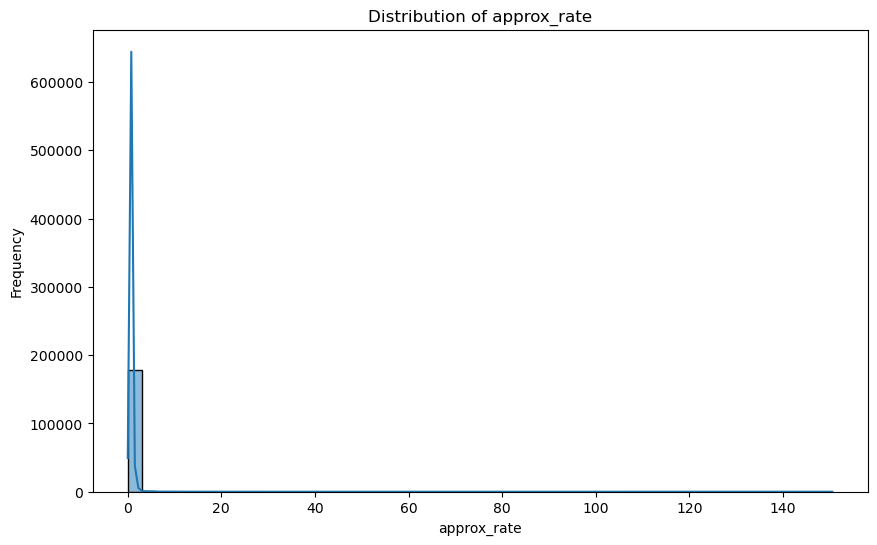

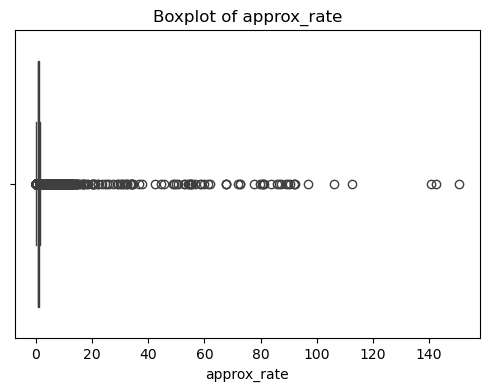

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Detailed quantiles at every 1% interval.
pd.set_option('display.max_rows', None)
quantiles = recipes['approx_rate'].quantile(np.arange(0, 1.005, 0.005))
print("Detailed Quantiles for approx_rate:")
print(quantiles)

# Plotting the histogram with a Kernel Density Estimate (KDE)
plt.figure(figsize=(10, 6))
sns.histplot(recipes['approx_rate'], bins=50, kde=True)
plt.title('Distribution of approx_rate')
plt.xlabel('approx_rate')
plt.ylabel('Frequency')
plt.show()

# Creating a boxplot to visualize outliers and distribution spread
plt.figure(figsize=(6, 4))
sns.boxplot(x=recipes['approx_rate'])
plt.title('Boxplot of approx_rate')
plt.xlabel('approx_rate')
plt.show()


In [ ]:

lower_bound = recipes['approx_rate'].quantile(0.225)
upper_bound = recipes['approx_rate'].quantile(0.980)

# Create a mask for rows with approx_rate in this range.
mask = (recipes['approx_rate'] >= lower_bound) & (recipes['approx_rate'] <= upper_bound)

# Count the rows that meet the condition.
count_in_range = mask.sum()

print(f"Number of rows with approx_rate between {lower_bound:.6f} and {upper_bound:.6f}: {count_in_range}")


Number of rows with approx_rate between 0.621861 and 1.665983: 134746


In [60]:
# Define the lower and upper bounds
lower_bound = 0.621861
upper_bound = 1.665983

# Filter the DataFrame to keep rows within the specified approx_rate range
recipes_filtered = recipes[(recipes['approx_rate'] >= lower_bound) & (recipes['approx_rate'] <= upper_bound)].copy()

# Optionally, if you want to update the original DataFrame, uncomment the following line:
# recipes = recipes_filtered.copy()

# Display the number of rows after filtering
print("Number of rows after dropping others:", recipes_filtered.shape[0])


Number of rows after dropping others: 134746


In [61]:
recipes_filtered.to_csv('recipes_filtered.csv', index=False)

In [65]:
ingredients = pd.read_csv('ingredients.csv')

In [66]:
ingredients.head()

,Unnamed: 0.1,Unnamed: 0,ingredient,energy_100g,carbohydrates_100g,proteins_100g,fat_100g
0,0,0,corned beef,895.0,0.5725,24.895,12.500
1,1,1,thousand island dressing,1380.8,15.7500,0.000,30.418
2,2,2,sauerkraut,71.0,3.3300,0.000,0.000
3,3,3,swiss cheese,1494.0,3.5700,28.570,28.570
4,4,4,rye bread,1046.0,45.7100,8.646,3.580


In [67]:
ingredients['energy_kcal_100g'] = ingredients['energy_100g'] / 4.184


In [69]:
ingredients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38055 entries, 0 to 38054
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0.1        38055 non-null  int64  
 1   Unnamed: 0          38055 non-null  int64  
 2   ingredient          38055 non-null  object 
 3   energy_100g         37800 non-null  float64
 4   carbohydrates_100g  37688 non-null  float64
 5   proteins_100g       37739 non-null  float64
 6   fat_100g            37697 non-null  float64
 7   energy_kcal_100g    37800 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 2.3+ MB


In [71]:


import numpy as np

# Example conversion function for range strings (e.g., '100-200')
def parse_amount(amt):
    if amt is None:
        return np.nan
    if isinstance(amt, str) and '-' in amt:
        try:
            parts = amt.split('-')
            # Compute the average of the range
            return (float(parts[0]) + float(parts[1])) / 2.0
        except Exception as e:
            return np.nan
    try:
        return float(amt)
    except Exception:
        return np.nan

# Function to process each recipe row
def process_recipe(row, ingredients):
    ingredients_list = row['ingredients']
    amounts_list = row['amount_gram']
    
    # Initialize accumulators for total nutrition and total weight
    total_weight = 0.0
    nutrition_sum = {
        'energy_100g': 0.0,
        'carbohydrates_100g': 0.0,
        'proteins_100g': 0.0,
        'fat_100g': 0.0,
        'energy_kcal_100g': 0.0
    }
    
    # Iterate over ingredients and corresponding amounts
    for ing, amt in zip(ingredients_list, amounts_list):
        amt_val = parse_amount(amt)
        if np.isnan(amt_val):
            continue  # Skip if amount is not available
        total_weight += amt_val

        # Look up the nutritional info for the ingredient; using a case-insensitive match may help
        ing_info = ingredients[ingredients['ingredient'].str.lower() == ing.lower()]
        if ing_info.empty:
            continue  # Skip if the ingredient is not found
        
        # Get nutrient values per 100g (if there are duplicates, take the first one)
        nutrition_sum['energy_100g'] += ing_info.iloc[0]['energy_100g'] * amt_val / 100.0
        nutrition_sum['carbohydrates_100g'] += ing_info.iloc[0]['carbohydrates_100g'] * amt_val / 100.0
        nutrition_sum['proteins_100g'] += ing_info.iloc[0]['proteins_100g'] * amt_val / 100.0
        nutrition_sum['fat_100g'] += ing_info.iloc[0]['fat_100g'] * amt_val / 100.0
        nutrition_sum['energy_kcal_100g'] += ing_info.iloc[0]['energy_kcal_100g'] * amt_val / 100.0

    # Avoid division by zero in case total_weight is zero
    if total_weight > 0:
        # Calculate per 100g nutritional values from the recipe total
        recipe_energy_per100g = (nutrition_sum['energy_100g'] / total_weight) * 100
        recipe_carbs_per100g = (nutrition_sum['carbohydrates_100g'] / total_weight) * 100
        recipe_proteins_per100g = (nutrition_sum['proteins_100g'] / total_weight) * 100
        recipe_fat_per100g = (nutrition_sum['fat_100g'] / total_weight) * 100
        recipe_energy_kcal_per100g = (nutrition_sum['energy_kcal_100g'] / total_weight) * 100

        # Calculate per serving nutritional values based on the serving size (in grams)
        serving_size = row['serving_size_numeric']
        recipe_energy_per_serving = (nutrition_sum['energy_100g'] / total_weight) * serving_size
        recipe_carbs_per_serving = (nutrition_sum['carbohydrates_100g'] / total_weight) * serving_size
        recipe_proteins_per_serving = (nutrition_sum['proteins_100g'] / total_weight) * serving_size
        recipe_fat_per_serving = (nutrition_sum['fat_100g'] / total_weight) * serving_size
        recipe_energy_kcal_per_serving = (nutrition_sum['energy_kcal_100g'] / total_weight) * serving_size
    else:
        recipe_energy_per100g = recipe_carbs_per100g = recipe_proteins_per100g = recipe_fat_per100g = recipe_energy_kcal_per100g = 0
        recipe_energy_per_serving = recipe_carbs_per_serving = recipe_proteins_per_serving = recipe_fat_per_serving = recipe_energy_kcal_per_serving = 0

    return pd.Series({
        'total_recipe_weight': total_weight,
        'recipe_energy_per100g': recipe_energy_per100g,
        'recipe_carbohydrates_per100g': recipe_carbs_per100g,
        'recipe_proteins_per100g': recipe_proteins_per100g,
        'recipe_fat_per100g': recipe_fat_per100g,
        'recipe_energy_kcal_per100g': recipe_energy_kcal_per100g,
        'recipe_energy_per_serving': recipe_energy_per_serving,
        'recipe_carbohydrates_per_serving': recipe_carbs_per_serving,
        'recipe_proteins_per_serving': recipe_proteins_per_serving,
        'recipe_fat_per_serving': recipe_fat_per_serving,
        'recipe_energy_kcal_per_serving': recipe_energy_kcal_per_serving
    })

# Example: apply the function to every row in recipes_filtered
recipes_filtered = recipes_filtered.copy()  
nutrition_data = recipes_filtered.apply(process_recipe, axis=1, ingredients=ingredients)

# Merge the computed nutrition columns into recipes_filtered
recipes_filtered = pd.concat([recipes_filtered, nutrition_data], axis=1)

print(recipes_filtered.head())


   Unnamed: 0.1  Unnamed: 0      id  \
0             1           1   76133   
1             4           4  392934   
2             5           6  489452   
4             7           9  318331   
5             9          12  384761   

                                                name  \
0                    Reuben and Swiss Casserole Bake   
1  Safe to Eat Raw Chocolate Chip Oreo Cookie &qu...   
2                                Teriyaki Pork Chops   
4                              Granny's Butter Rolls   
5                          Chocolate Mousse Cupcakes   

                                         description  \
0  I think this is even better than a reuben sand...   
1  I was searching the web for something like thi...   
2  I made these on a whim and they are my husband...   
4  Recipe from Crystal Van Poppe in her booklet "...   
5  From The Cupcake Deck by Elinor Klivans.The ad...   

                                     ingredients_raw  \
0  ["1/2-1   lb    corned beef, coo

In [78]:
recipes_filtered.to_csv('filtered_recipes.csv', index=False)

In [80]:
# At the end we have obtained a filtered recipes dataframe with nutritional values for each recipe. 
# We can now use this dataframe for LLM's usage/training.
recipes_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134746 entries, 0 to 178995
Data columns (total 26 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   id                                134746 non-null  int64  
 1   name                              134746 non-null  object 
 2   description                       134078 non-null  object 
 3   ingredients_raw                   134746 non-null  object 
 4   steps                             134746 non-null  object 
 5   servings                          134746 non-null  float64
 6   serving_size                      134746 non-null  object 
 7   tags                              134746 non-null  object 
 8   ingredients                       134746 non-null  object 
 9   amounts                           134746 non-null  object 
 10  amount_gram                       134746 non-null  object 
 11  serving_size_numeric              134746 non-null  float6